In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import seaborn as sns
import torch
import torch.nn as nn
from torchsummary import summary
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import json

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)l

Device: cpu


#### 1. Open Data

In [2]:
path_data = "C:/Users/62812/Documents/Kuliah/Semester 2/Proyek Penelitian Terapan/Data Clean/Sejabar/"
file_data = "Data Pollutan dan Weather Jabar.nc"
xr_data = xr.open_dataset(path_data+file_data)
#masukan semua value kedalam array
val_data = xr_data['PollutanWeather'].values
# val_precip = val_data[-1,:,:,:] * 1000
# val_data[-1,:,:,:] = val_precip
data_time = xr_data['time'].values
#list semua variabel yang ada pada data
var_data = list(xr_data['variable'].values)

lat_data = xr_data['latitude'].values
lon_data = xr_data['longitude'].values

#drop value yang tidak digunakan
var_drop = ['nh3','no','wind_gust','precip','temp']

print(f"Varibel sebelum di drop: {var_data}")
print(f"Shape data sebelum di drop: {val_data.shape}")

Varibel sebelum di drop: ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'temp', 'humidity', 'pressure', 'wind_deg', 'wind_speed', 'wind_gust', 'precip']
Shape data sebelum di drop: (15, 8575, 20, 25)


#### 2. Drop Variable

In [3]:
#mengubah data nan dan data kosong menjadi -1
data_replace = -1
val_data[np.isnan(val_data)] = data_replace
val_data[val_data == 9999] = data_replace

def drop_var_data(data,data_var,drop_var):
    new_data = []
    new_var = []
    for n,var in enumerate(data_var):
        if var not in drop_var:
            new_data.append(data[n,:,:,:])
            new_var.append(var)
    return np.array(new_data), new_var

val_data, var_data = drop_var_data(val_data,var_data,var_drop)
pollutan_var = var_data[0:6]
print(f"Variabel data setelah di drop: {var_data}")
print(f"Shape data setelah di drop: {val_data.shape}")

Variabel data setelah di drop: ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'humidity', 'pressure', 'wind_deg', 'wind_speed']
Shape data setelah di drop: (10, 8575, 20, 25)


#### 3. Visualisasi Data

max val for co is 69213.87


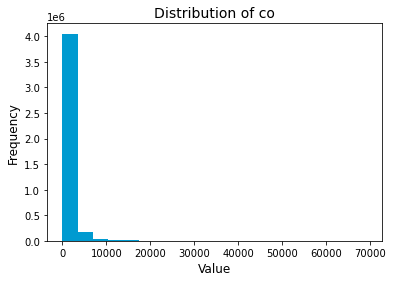

max val for no2 is 701.9


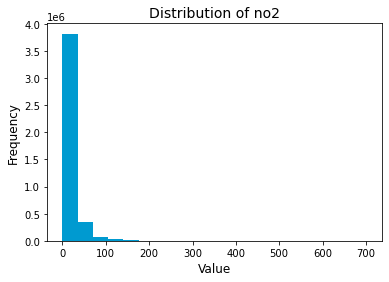

max val for o3 is 1110.08


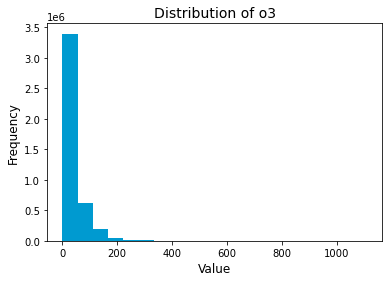

max val for so2 is 442.5


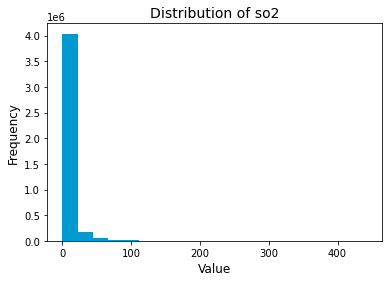

max val for pm2_5 is 2461.93


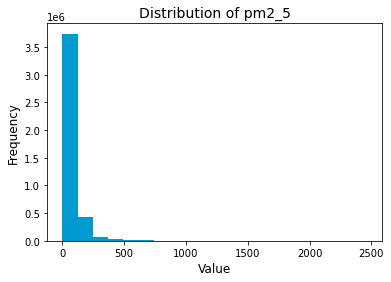

max val for pm10 is 2968.86


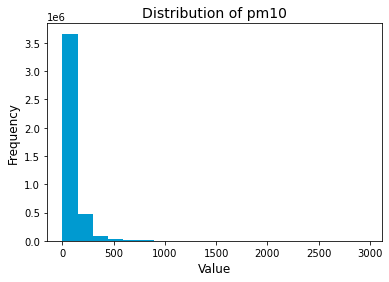

max val for humidity is 100.0


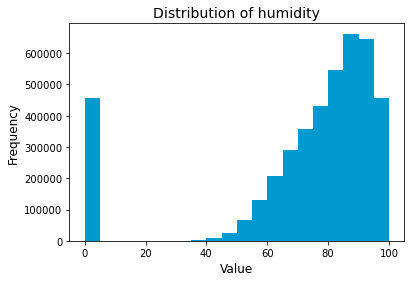

max val for pressure is 1029.0


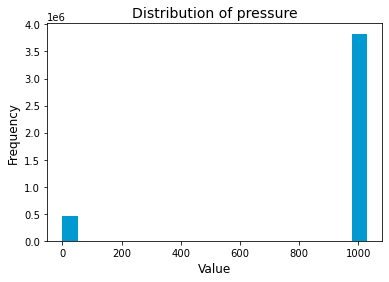

max val for wind_deg is 360.0


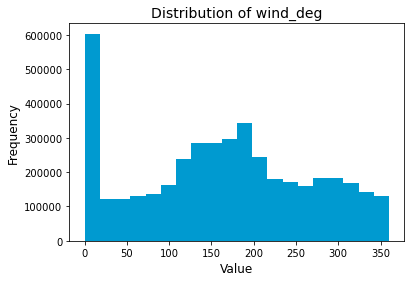

max val for wind_speed is 22.35


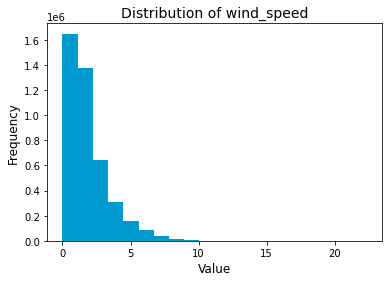

In [57]:
for n,var in enumerate(var_data):
    # Plot the histogram
    data = val_data[n,:,:,:]
    print(f"max val for {var} is {np.max(data)}")
    plt.hist(data[np.where(data>=0)], bins=20, color='#009AD0')
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Distribution of {var}', fontsize=14)
    plt.show()

#### Normalisasi Data dan reshape data

In [4]:
#fungsi reshape data digunakan untuk mengubah dimensi var,time,lat,lon menjadi time,var,lat,lon
def reshape_data(val_data):
    val_data_reshaped = []
    for i in range(val_data.shape[1]):
        val_data_reshaped.append(val_data[:,i,:,:])
    val_data_reshaped = np.array(val_data_reshaped)
    return val_data_reshaped
def totensor(arr):
    ts = torch.from_numpy(np.float32(arr))
    return ts

In [5]:
print(f"Val data before reshape has shape {val_data.shape}")
val_data_rs = reshape_data(val_data)
print(f"Val data after reshape has shape {val_data_rs.shape} \n")

Val data before reshape has shape (10, 8575, 20, 25)
Val data after reshape has shape (8575, 10, 20, 25) 



In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#fungsi yang digunakan untuk normalisasi data 
def norm_minmax(data,features):
    scaler_minmax = {}
    scaled_data = data.copy()
    for n, var in enumerate(features):
        #scaler_var = MinMaxScaler(feature_range = (0,1))
        scaler_var = StandardScaler()
        val_var = data[:,n,:,:].flatten().reshape(-1,1)
        scaled_var = scaler_var.fit_transform(val_var)
        scaler_minmax[var] = scaler_var
        scaled_data[:,n,:,:] = scaled_var.flatten().reshape(data[:,n,:,:].shape)
    return scaled_data, scaler_minmax

#fungsi yang digunakan untuk mengembalikan ke nilai semua setelah di normalisasi
def inverse_norm_minmax(scaled_data,features, scaler_minmax):
    inverse_scaled_data = scaled_data.copy()
    for n, var in enumerate(features):
        scaler_var = scaler_minmax[var]
        scaled_val_var =  scaled_data[:,n,:,:].flatten().reshape(-1,1)
        inverse_scaled_var = scaler_var.inverse_transform(scaled_val_var)
        inverse_scaled_data[:,n,:,:] = inverse_scaled_var.flatten().reshape(scaled_data[:,n,:,:].shape)
    return inverse_scaled_data

In [7]:
val_data_rs.shape

(8575, 10, 20, 25)

In [8]:
val_data_scaled, scaler_minmax = norm_minmax(val_data_rs, var_data)

val_data_inverse = inverse_norm_minmax(val_data_scaled,var_data,scaler_minmax)

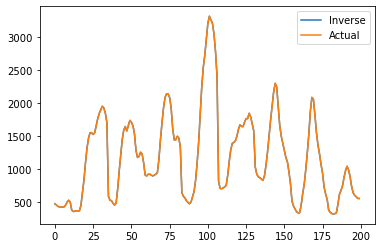

In [9]:
plt.plot(val_data_inverse[0:200,0,5,5], label = 'Inverse')
plt.plot(val_data_rs[0:200,0,5,5], label = 'Actual')
plt.legend()
plt.show()

In [10]:
#Digunakan saat data train tidak dipisah
size_test = 100
data_train, y_test = val_data_scaled[0:-size_test,:,:,:], val_data_scaled[-size_test:,:,:,:]
print(f"data train shape : {data_train.shape} and y_test shape :{y_test.shape}")

data train shape : (8475, 10, 20, 25) and y_test shape :(100, 10, 20, 25)


In [11]:
n_features, n_lat,n_lon = val_data_scaled.shape[-3:]
n_features, n_lat,n_lon

(10, 20, 25)

#### 5. Encoder

In [12]:
config_convs = {
    #height adalah panjang latitude, Width adalah panjang longitude
    "Height" : n_lat,
    "Width": n_lon,
    "KernelHeight": [3,3,3], #index pertama adalah filter pada layer pertama
    "KernelWidth": [3,3,3],
    "padding": [0,0,0],
    "stride" : [1,1,1],
    "num_of_filters" : [64,16,1]
}

In [13]:
#fungsi OutShape digunakan untuk menghitung output shape setelah di convolusi
def OutShape(Height,Width,KernelHeight,KernelWidth,padding,stride):
    OutH = ((Height + (2*padding[0]) - KernelHeight[0])/stride[0]) + 1
    OutW = ((Width + (2*padding[0]) - KernelWidth[0])/stride[0]) + 1
    if (len(KernelWidth) == 1):
        return (1,1,int(OutH),int(OutW))
    else:
        return OutShape(OutH,OutW,KernelHeight[1:],KernelWidth[1:],padding[1:],stride[1:])
    
encode_shape = OutShape(config_convs["Height"],config_convs["Width"],config_convs["KernelHeight"],
                        config_convs["KernelWidth"],config_convs["padding"],config_convs["stride"])

fc_dim = encode_shape[-1] * encode_shape[-2] * config_convs['num_of_filters'][-1]

In [14]:
class Encoder(nn.Module):
    def __init__(self,config_convs, n_features, fc_dim , output_dim , use_batchnorm=True, use_dropout=True):
        super(Encoder, self).__init__()
        
        #bottleneck dimentionality
        self.output_dim = output_dim
        self.n_features = n_features
        
        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm
        
        #Convolutional layer hyper parameters
        self.layers = len(config_convs['KernelHeight'])
        self.kernels = config_convs['KernelHeight']
        self.channels = config_convs['num_of_filters']
        self.strides = config_convs['stride']
        self.padding = config_convs['padding']
        self.conv = self.get_convs()
        
        #layers for latent space projection
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(fc_dim, self.output_dim)
    
    def get_convs(self):
        """
        Generating convolutional layers based on our config hypers parameters
        """
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            if i == 0:
                conv_layers.append(nn.Conv2d(in_channels = self.n_features,
                                            out_channels = self.channels[i],
                                            kernel_size = self.kernels[i],
                                            stride = self.strides[i],
                                            padding = self.padding[i]))
            else:
                conv_layers.append(nn.Conv2d(in_channels = self.channels[i-1],
                                            out_channels = self.channels[i],
                                            kernel_size = self.kernels[i],
                                            stride = self.strides[i],
                                            padding = self.padding[i]))
            if self.use_batchnorm:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))
            
            conv_layers.append(nn.GELU()) # Here we use GELU as activation function
            
            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))
            
        return conv_layers
    
    def forward(self,x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [15]:
laten_len = 10
encoder = Encoder(config_convs, n_features, fc_dim , output_dim = laten_len)
summary(encoder, val_data_scaled.shape[-3:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 18, 23]           5,824
       BatchNorm2d-2           [-1, 64, 18, 23]             128
              GELU-3           [-1, 64, 18, 23]               0
         Dropout2d-4           [-1, 64, 18, 23]               0
            Conv2d-5           [-1, 16, 16, 21]           9,232
       BatchNorm2d-6           [-1, 16, 16, 21]              32
              GELU-7           [-1, 16, 16, 21]               0
         Dropout2d-8           [-1, 16, 16, 21]               0
            Conv2d-9            [-1, 1, 14, 19]             145
      BatchNorm2d-10            [-1, 1, 14, 19]               2
             GELU-11            [-1, 1, 14, 19]               0
        Dropout2d-12            [-1, 1, 14, 19]               0
          Flatten-13                  [-1, 266]               0
           Linear-14                   

#### 6. Decoder

In [16]:
class Decoder(nn.Module):
    def __init__(self,config_convs, n_features, fc_dim , encode_shape, input_dim, use_batchnorm=True, use_dropout=True):
        super(Decoder, self).__init__()
        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm
        
        #bottleneck dimentionality
        self.input_dim = input_dim
        self.n_features = n_features
        self.encode_shape = encode_shape
        
        #Convolutional layer hyper parameters
        self.layers = len(config_convs['KernelHeight'])
        self.kernels = config_convs['KernelHeight'][::-1]
        self.channels = config_convs['num_of_filters'][::-1]
        self.strides = config_convs['stride'][::-1]
        self.padding = config_convs['padding'][::-1]
        self.conv = self.get_convs()
        
        #in decoder, first we do the fully connected layer then the conv layer
        self.fc = nn.Linear(input_dim, fc_dim)
        self.conv = self.get_convs()
        self.output = nn.Conv2d(in_channels = self.channels[-1], out_channels = n_features, kernel_size = 1, stride = 1)
        
    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            if i == 0:
                conv_layers.append(nn.ConvTranspose2d(in_channels = self.channels[i],
                                            out_channels = self.channels[i],
                                            kernel_size = self.kernels[i],
                                            stride = self.strides[i],
                                            padding = self.padding[i]))
            else:
                conv_layers.append(nn.ConvTranspose2d(in_channels = self.channels[i-1],
                                            out_channels = self.channels[i],
                                            kernel_size = self.kernels[i],
                                            stride = self.strides[i],
                                            padding = self.padding[i]))
            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.GELU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))
                
        return conv_layers
    
    def forward(self,x):
        x = self.fc(x)
        x = x.reshape(self.encode_shape)
        x = self.conv(x)
        x = self.output(x)
        return x

In [17]:
decoder = Decoder(config_convs, n_features, fc_dim , encode_shape, laten_len)

#### 7. AutoEncoder

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self,x):
        x = self.encoder(x)
        return self.decoder(x)

#### 8. Train AutoEncoder

In [19]:
def trainAE(modelAE, train_data, criterion , optimizer, epochs, device,n_features, n_lat,n_lon):
    modelAE.train()
    train_loss = []
    for epoch in range(epochs):
        for idx in range(len(train_data)):
            X = train_data[idx].view(1,n_features, n_lat,n_lon).to(device)
            y = train_data[idx].view(1,n_features, n_lat,n_lon).to(device)
            
            #forward pass 
            output = modelAE(X)
            
            #Calculate MSE error
            loss = criterion(output, y)
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        print(f"Epoch {epoch + 1}/{epochs} with loss {loss.item():.4f}")
    return modelAE, train_loss

In [20]:
torch.manual_seed(24)
modelAE = AutoEncoder(encoder,decoder).to(device)
lr = 0.001
epochs = 20

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelAE.parameters(), lr = lr)

In [32]:
modelAE, train_loss = trainAE(modelAE, totensor(data_train), criterion, optimizer, epochs , device, n_features, n_lat, n_lon)

### Save Model

In [ ]:
PATH_MODEL = "C:/Users/62812/Documents/Kuliah/Semester 2/Proyek Penelitian Terapan/Hasil Model Eksperimen 2/"
file_models = os.listdir(PATH_MODEL)
n = int(len(file_models)/2) + 1
torch.save(modelAE.state_dict(), PATH_MODEL+f"Model {n}.pt")

model_details = {
    "Data raw" : file_data,
    "Data replace" : 0,
    "Variabel" : var_data,
    "Size test" : size_test,
    "Len laten" :laten_len,
    "Learning Rate" : lr,
    "Epochs": epocin_loshs,
    "Convs config" : config_convs,
    "Error train" : tras
}
  
with open(PATH_MODEL+f'Keterangan Model {n}.txt', 'w') as f:
     for key,value in model_details.items():
            f.write(key+ ": " +str(value) + '\n')

#### Load Model AutoEncoder

In [ ]:
path_modelAE =  "C:/Users/62812/Documents/Kuliah/Semester 2/Proyek Penelitian Terapan/Hasil Model Eksperimen 2/Model 11.pt"
encoder = Encoder(config_convs, n_features, fc_dim , output_dim = laten_len)
decoder = Decoder(config_convs, n_features, fc_dim , encode_shape, input_dim = laten_len)
modelAE = AutoEncoder(encoder,decoder)
modelAE.load_state_dict(torch.load(path_modelAE))
modelAE.eval()

In [21]:
path_modelAE =  "C:/Users/62812/Documents/Kuliah/Semester 2/Proyek Penelitian Terapan/Hasil Model Eksperimen 2/Model 11.pt"
encoder = Encoder(config_convs, n_features, fc_dim , output_dim = laten_len)
decoder = Decoder(config_convs, n_features, fc_dim , encode_shape, input_dim = laten_len)
modelAE = AutoEncoder(encoder,decoder)
modelAE.load_state_dict(torch.load(path_modelAE))
modelAE.eval()

AutoEncoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Dropout2d(p=0.15, inplace=False)
      (4): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): GELU(approximate='none')
      (7): Dropout2d(p=0.15, inplace=False)
      (8): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
      (9): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): GELU(approximate='none')
      (11): Dropout2d(p=0.15, inplace=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=266, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
      (1):

In [22]:
def predict(modelAE,y_test,n_features, n_lat,n_lon):
    predicted = []
    for i in range(len(y_test)):
        out_y = modelAE(totensor(y_test[i]).view(1,n_features, n_lat, n_lon))
        predicted.append(out_y[0].detach().numpy())
    return np.array(predicted)

In [23]:
predicted_y = predict(modelAE,y_test,n_features, n_lat,n_lon)

predicted_real = inverse_norm_minmax(predicted_y,var_data,scaler_minmax)
y_test_real = inverse_norm_minmax(y_test,var_data, scaler_minmax)

In [24]:
y_test_real.shape

(100, 10, 20, 25)

In [25]:
#array to NC file
def make_nc4D(data_array,time,variable,lat,lon,parameter,output_name):
    #encode = {parameter: {"zlib":True, "complevel":9}}
    dxr = xr.Dataset(
    {"{}".format(parameter): (("time","variable","latitude", "longitude"), data_array)},
    coords={
        "time": time,
        "variable" : variable,
        "latitude": lat,
        "longitude": lon,
        })
    dxr.to_netcdf("{}.nc".format(output_name)) #,encoding = encode)

In [26]:
data_lat = xr_data['latitude'].values
data_lon = xr_data['longitude'].values

make_nc4D(predicted_real,data_time[-size_test:],var_data,data_lat,data_lon,"Pollutan Weather",f"Predicted Output Decoder Model {n}")
make_nc4D(y_test_real,data_time[-size_test:],var_data,data_lat,data_lon,"Pollutan Weather","Actual Data")

In [27]:
def RMSE_3D(actual,predicted,var_data):
    rmse = {}
    for v in range(actual.shape[1]):
        error_var_t = [] 
        for t in range(actual.shape[0]):
            #get value of variabel v at time t, and flatten so we can calculate the mse
            val_actual = actual[t,v,:,:].flatten()
            val_predicted = predicted[t,v,:,:].flatten()
            #calculate the rmse 
            rmse_var = np.sqrt(mean_squared_error(val_actual, val_predicted))
            #add the rmse to list
            error_var_t.append(rmse_var)
        rmse[var_data[v]] = error_var_t
    return rmse

In [28]:
RMSE_AE = RMSE_3D(y_test_real[0:24],predicted_real[0:24],var_data)

In [29]:
df_rmse_ae = pd.DataFrame(RMSE_AE)
#df_rmse_ae.to_excel(f"RMSE Auto Encoder Model {n}.xlsx")

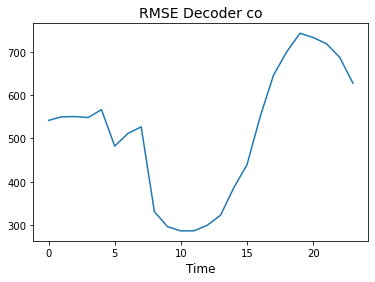

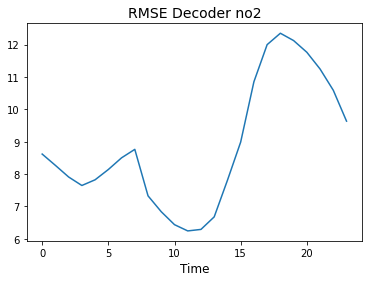

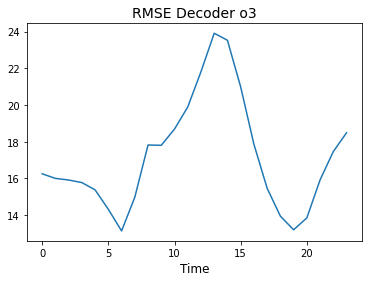

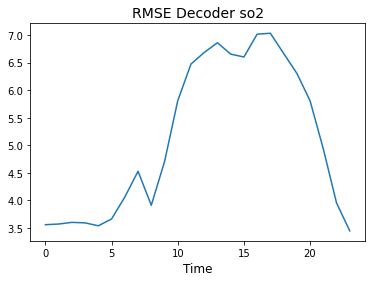

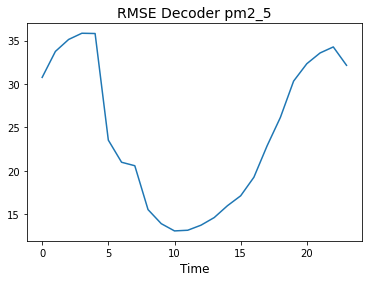

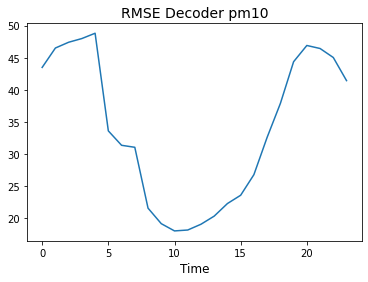

In [30]:
for n,var in enumerate(pollutan_var):
    # Plot the histogram
    error_var = RMSE_AE[var]
    #t_24 = np.arange(1,25)
    plt.plot(error_var)
    plt.xlabel('Time', fontsize=12)
    #plt.ylabel('RMSE', fontsize=12)
    plt.title(f'RMSE Decoder {var}', fontsize=14)
    plt.show()

In [31]:
for i in range(len(y_test)):
    L = criterion(totensor(predicted_y[i]), totensor(y_test[i]))
    print(L.item())
    if i == 10:
        break

0.1890227049589157
0.20451787114143372
0.2153172343969345
0.2092815488576889
0.2132161557674408
0.19665522873401642
0.20804965496063232
0.21937254071235657
0.22329428791999817
0.20214572548866272
0.2827383577823639


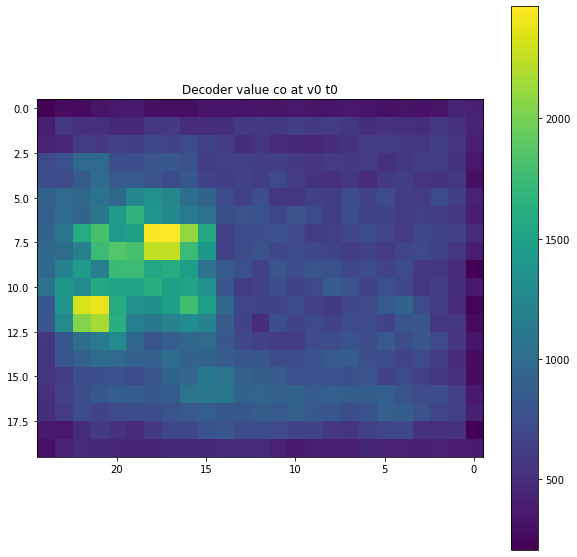

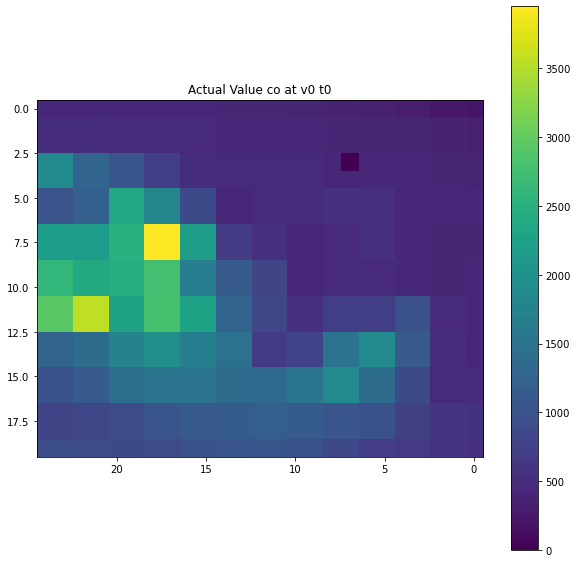

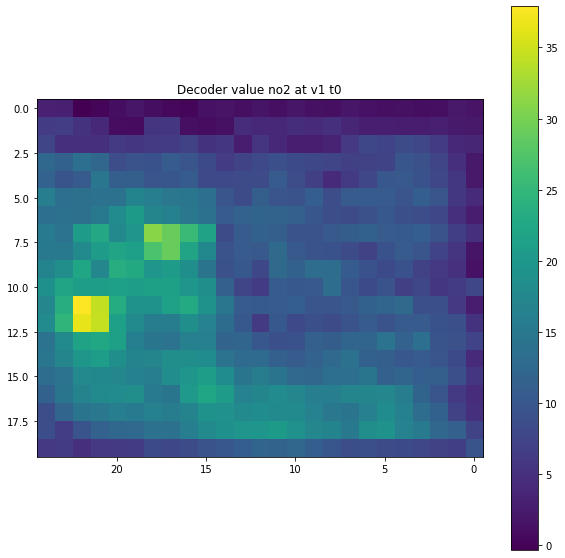

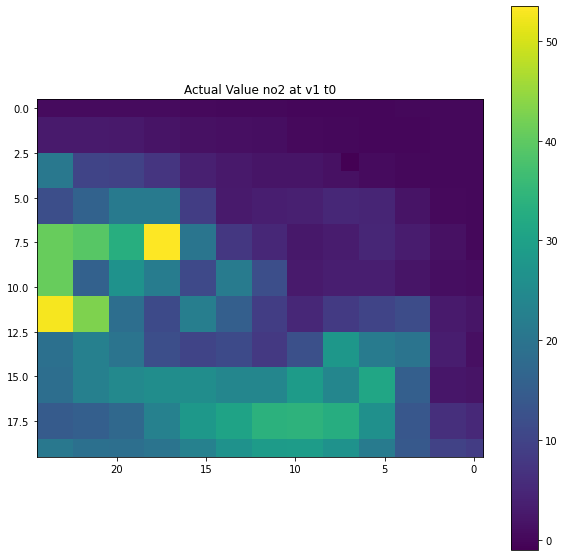

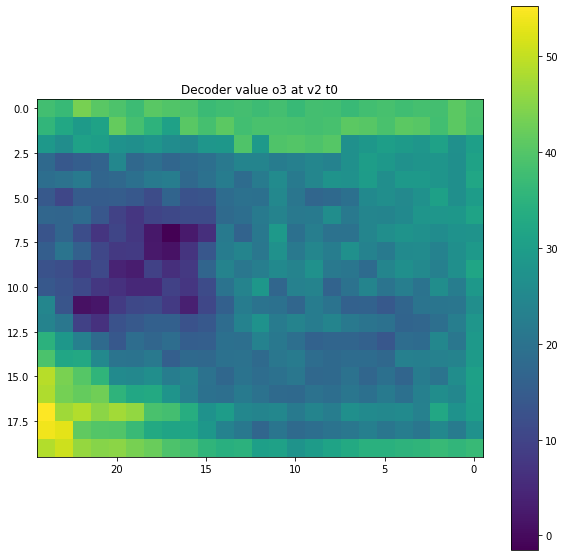

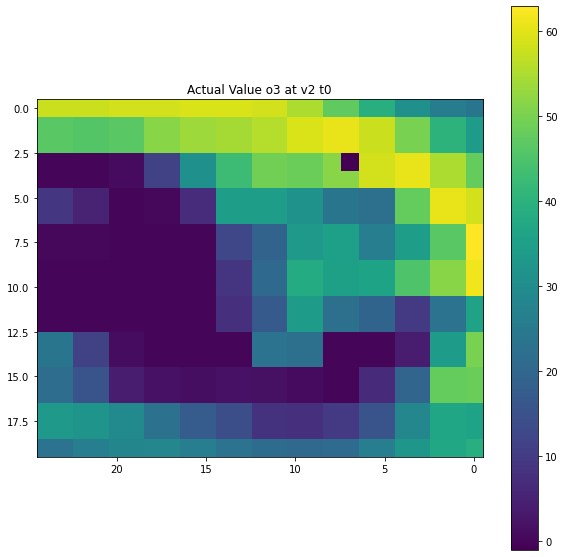

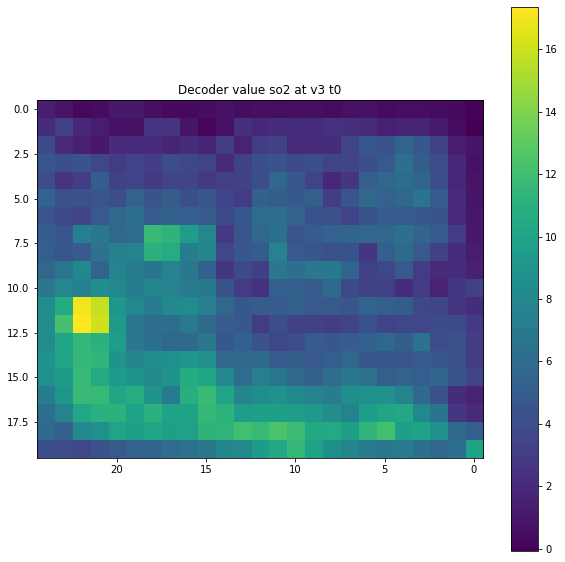

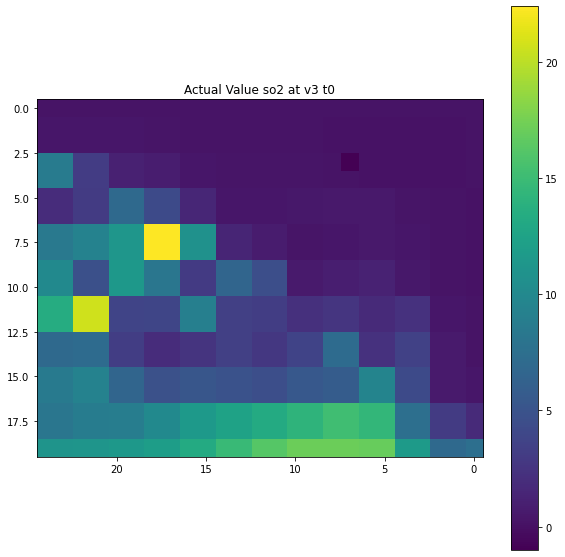

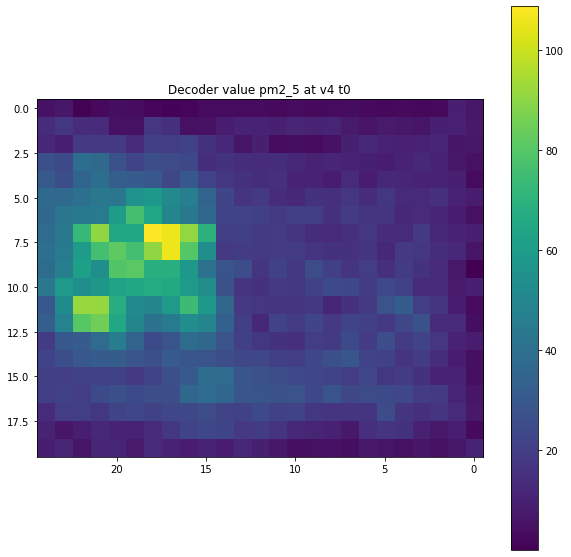

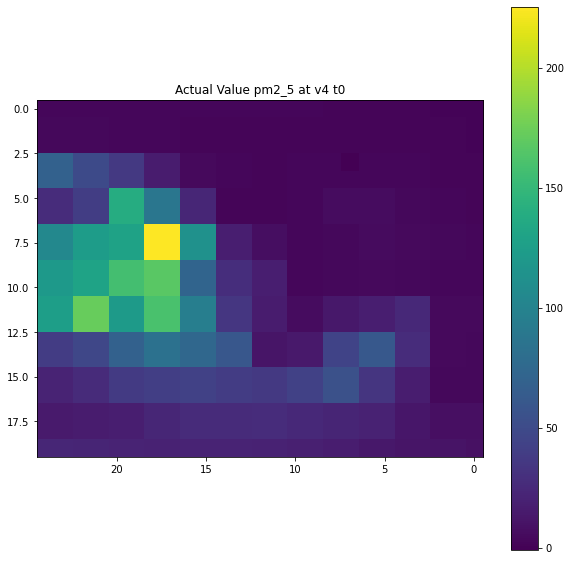

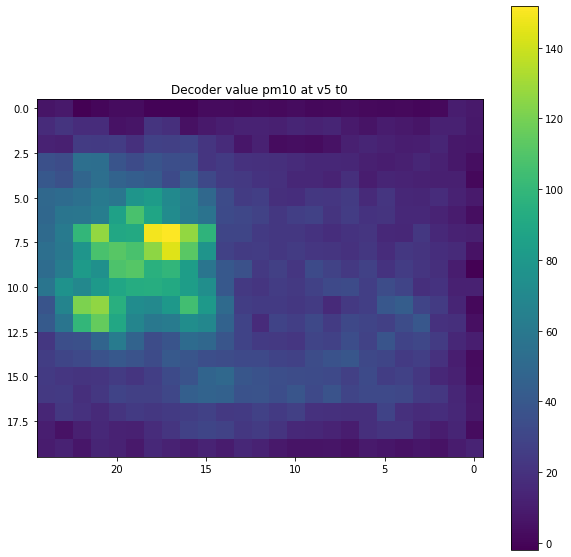

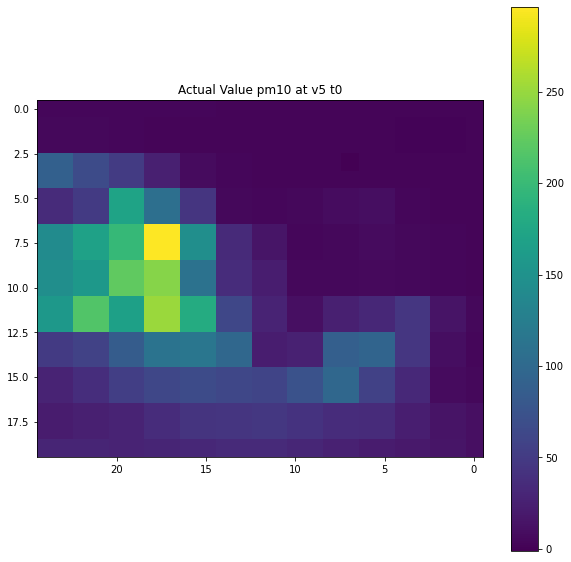

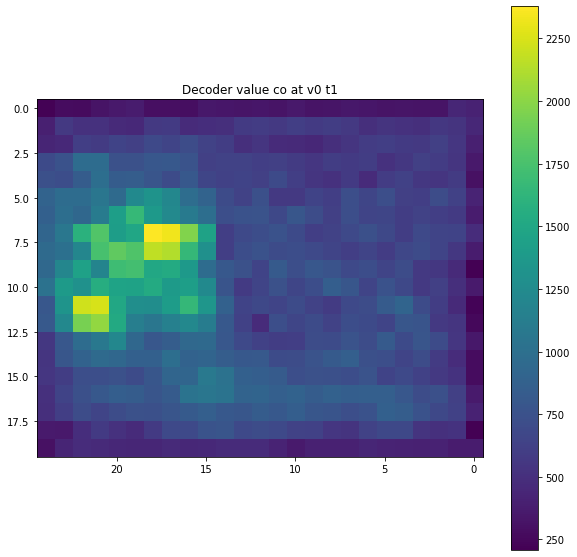

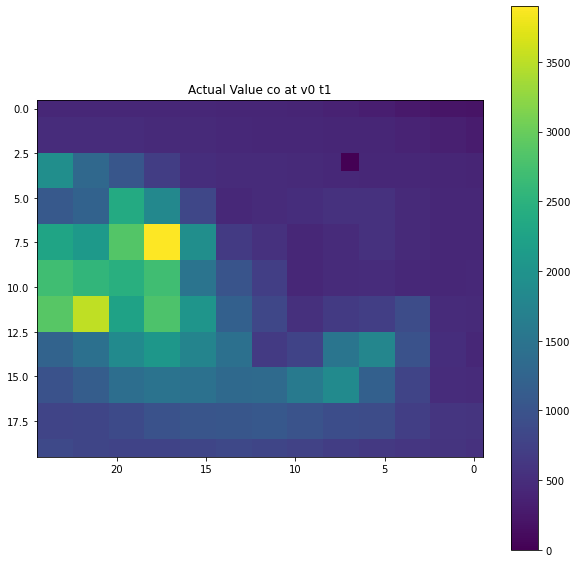

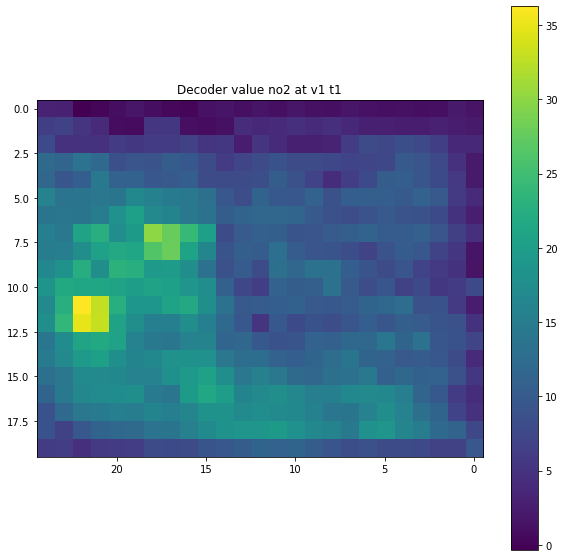

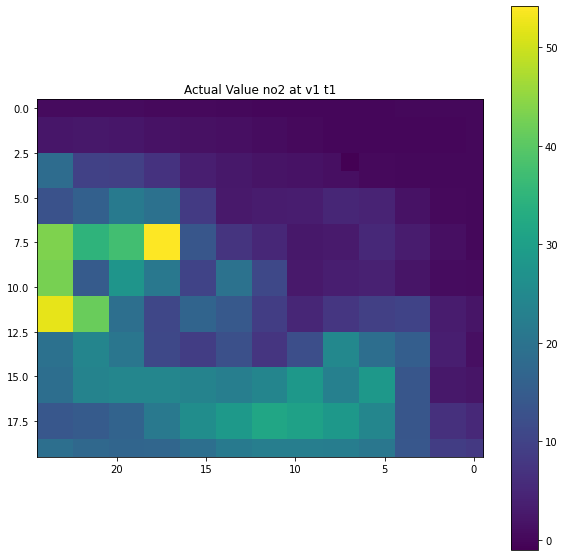

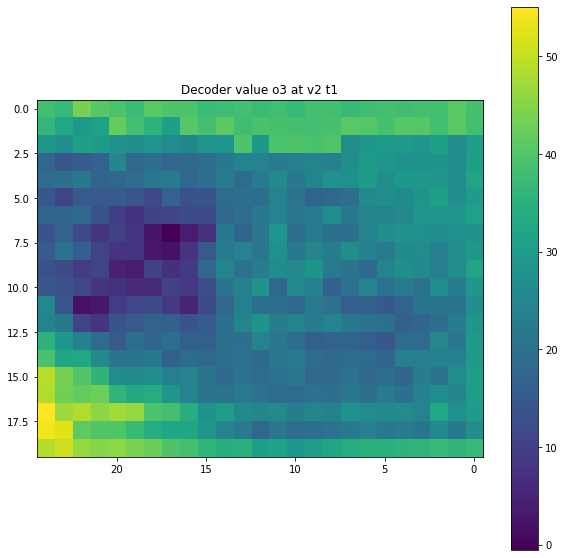

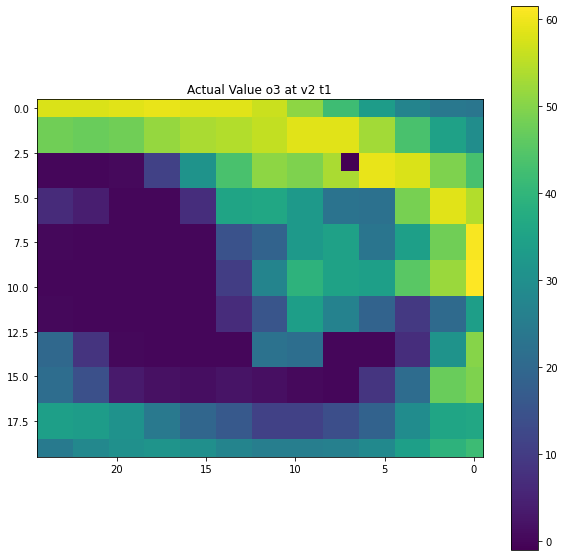

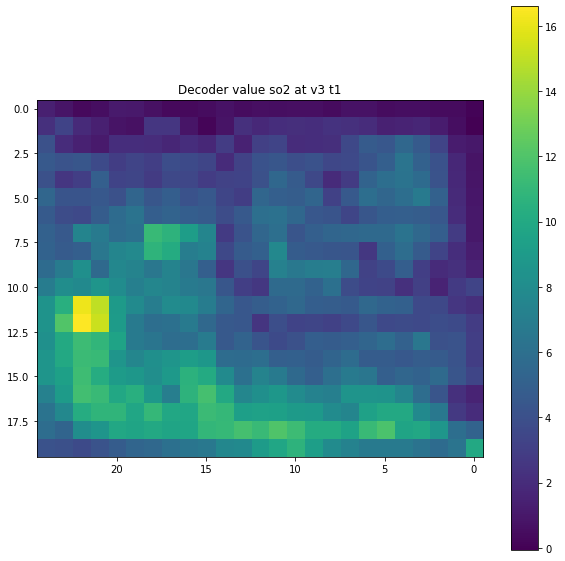

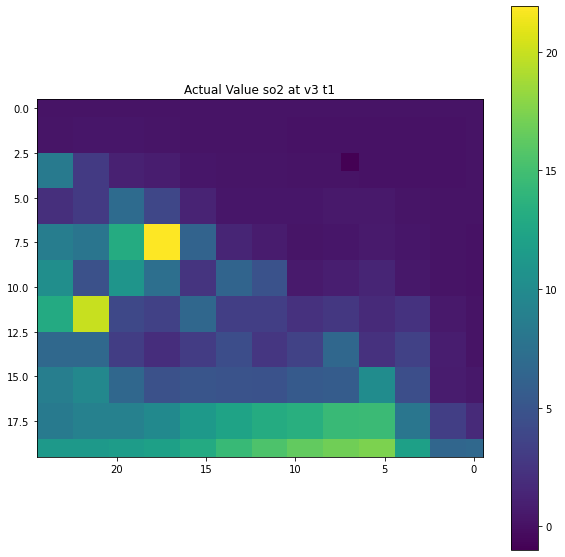

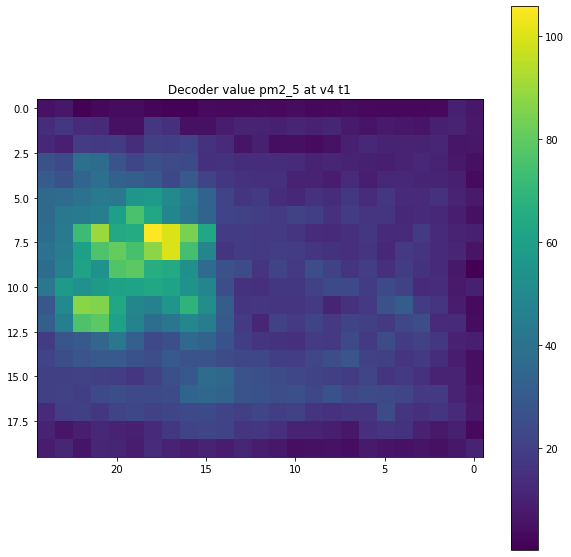

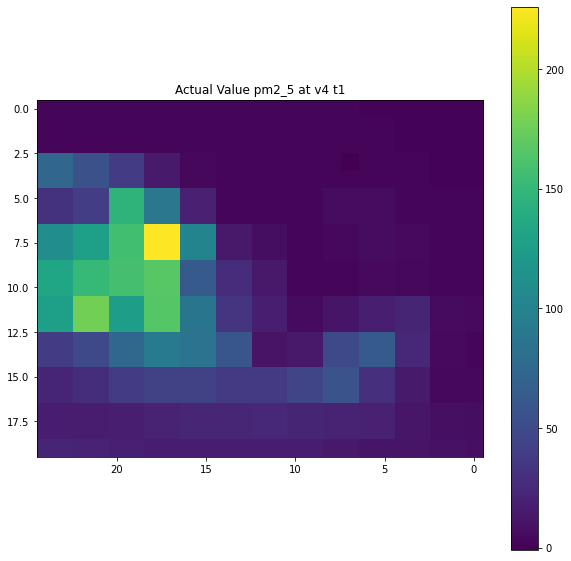

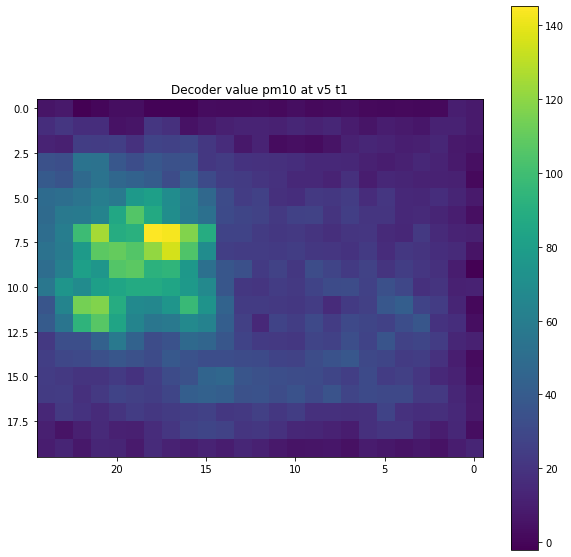

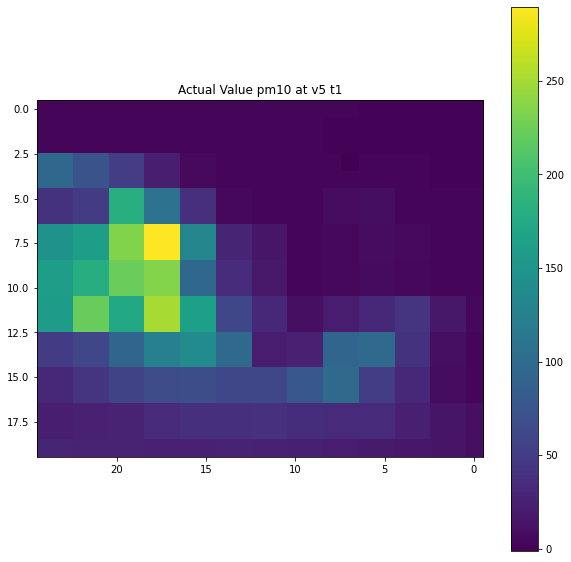

In [32]:
# create a figure with a larger size
for t in range(2):
    for v in range(6):
        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.imshow(predicted_real[t,v,:,:], cmap='viridis')
        ax.invert_xaxis()
        plt.colorbar(im)
        ax.set_title(f"Decoder value {var_data[v]} at v{v} t{t}")
        plt.show()


        # create a figure with a larger size
        fig, ax1 = plt.subplots(figsize=(10, 10))
        im1 = ax1.imshow(y_test_real[t,v,:,:], cmap='viridis')
        ax1.invert_xaxis()
        plt.colorbar(im1)
        ax1.set_title(f"Actual Value {var_data[v]} at v{v} t{t}")
        plt.show()
    if n == 2:
        break
    n+=1

#### Encode Data

In [33]:
#Ambil data laten saja untuk model LSTM/GRU
def encode_data(data_train,modelAE):
    laten_val = []
    for i in range(data_train.shape[0]):
        with torch.no_grad():
            z = modelAE.encoder(totensor(data_train[i]).view(1,n_features,n_lat,n_lon))
            laten_val.append(z[0].detach().numpy())
    return np.array(laten_val)

#fungsi data loader untuk membuat data time series menjadi data input dan data target
def many_to_one_laten(raw_series,len_seq): # len_seq adalah panjang sequence, len_target adalah panjang target  
    data = []
    target = []
    for i in range(raw_series.shape[0]-len_seq):
        data.append(raw_series[i:len_seq+i])
        target.append(raw_series[len_seq+i])

    data = totensor(data)
    target = totensor(target)
    return data,target

In [34]:
data_train.shape

(8475, 10, 20, 25)

In [35]:
#laten val adalah data yang sudah dikecilkan dimensinya untuk masukan model LSTM/GRU
laten_val = encode_data(data_train,modelAE)

In [36]:
#set constan value 
len_seq = 48
size_test = 24

In [37]:
#dm adalah distance musim, artinya jarak data antar musim
dm = int(laten_val.shape[0]/4)

#pisahkan data raw per musim 
raw_mam, raw_jja, raw_son, raw_djf = val_data_rs[0:dm], val_data_rs[dm:2*dm], val_data_rs[2*dm:3*dm], val_data_rs[3*dm:4*dm]
time_mam, time_jja, time_son, time_djf = data_time[0:dm], data_time[dm:2*dm], data_time[2*dm:3*dm], data_time[3*dm:4*dm]

#data test actual per musim
actual_mam, actual_jja, actual_son, actual_djf = raw_mam[-size_test:],raw_jja[-size_test:],raw_son[-size_test:],raw_djf[-size_test:]

# Pisahkan laten value per musim
laten_mam, laten_jja, laten_son, laten_djf = laten_val[0:dm], laten_val[dm:2*dm], laten_val[2*dm:3*dm], laten_val[3*dm:4*dm]
laten_mam.shape, laten_jja.shape, laten_son.shape, laten_djf.shape

((2118, 10), (2118, 10), (2118, 10), (2118, 10))

In [41]:
print(time_mam[-size_test:])

['2022-06-08T13:00:00.000000000' '2022-06-08T14:00:00.000000000'
 '2022-06-08T15:00:00.000000000' '2022-06-08T16:00:00.000000000'
 '2022-06-08T17:00:00.000000000' '2022-06-08T18:00:00.000000000'
 '2022-06-08T19:00:00.000000000' '2022-06-08T20:00:00.000000000'
 '2022-06-08T21:00:00.000000000' '2022-06-08T22:00:00.000000000'
 '2022-06-08T23:00:00.000000000' '2022-06-09T00:00:00.000000000'
 '2022-06-09T01:00:00.000000000' '2022-06-09T02:00:00.000000000'
 '2022-06-09T03:00:00.000000000' '2022-06-09T04:00:00.000000000'
 '2022-06-09T05:00:00.000000000' '2022-06-09T06:00:00.000000000'
 '2022-06-09T07:00:00.000000000' '2022-06-09T08:00:00.000000000'
 '2022-06-09T09:00:00.000000000' '2022-06-09T10:00:00.000000000'
 '2022-06-09T11:00:00.000000000' '2022-06-09T12:00:00.000000000']


In [42]:
print(time_jja[-size_test:])

['2022-09-04T19:00:00.000000000' '2022-09-04T20:00:00.000000000'
 '2022-09-04T21:00:00.000000000' '2022-09-04T22:00:00.000000000'
 '2022-09-04T23:00:00.000000000' '2022-09-05T00:00:00.000000000'
 '2022-09-05T01:00:00.000000000' '2022-09-05T02:00:00.000000000'
 '2022-09-05T03:00:00.000000000' '2022-09-05T04:00:00.000000000'
 '2022-09-05T05:00:00.000000000' '2022-09-05T06:00:00.000000000'
 '2022-09-05T07:00:00.000000000' '2022-09-05T08:00:00.000000000'
 '2022-09-05T09:00:00.000000000' '2022-09-05T10:00:00.000000000'
 '2022-09-05T11:00:00.000000000' '2022-09-05T12:00:00.000000000'
 '2022-09-05T13:00:00.000000000' '2022-09-05T14:00:00.000000000'
 '2022-09-05T15:00:00.000000000' '2022-09-05T16:00:00.000000000'
 '2022-09-05T17:00:00.000000000' '2022-09-05T18:00:00.000000000']


In [43]:
print(time_son[-size_test:])

['2022-12-02T01:00:00.000000000' '2022-12-02T02:00:00.000000000'
 '2022-12-02T03:00:00.000000000' '2022-12-02T04:00:00.000000000'
 '2022-12-02T05:00:00.000000000' '2022-12-02T06:00:00.000000000'
 '2022-12-02T07:00:00.000000000' '2022-12-02T08:00:00.000000000'
 '2022-12-02T09:00:00.000000000' '2022-12-02T10:00:00.000000000'
 '2022-12-02T11:00:00.000000000' '2022-12-02T12:00:00.000000000'
 '2022-12-02T13:00:00.000000000' '2022-12-02T14:00:00.000000000'
 '2022-12-02T15:00:00.000000000' '2022-12-02T16:00:00.000000000'
 '2022-12-02T17:00:00.000000000' '2022-12-02T18:00:00.000000000'
 '2022-12-02T19:00:00.000000000' '2022-12-02T20:00:00.000000000'
 '2022-12-02T21:00:00.000000000' '2022-12-02T22:00:00.000000000'
 '2022-12-02T23:00:00.000000000' '2022-12-03T00:00:00.000000000']


In [44]:
print(time_djf[-size_test:])

['2023-02-28T07:00:00.000000000' '2023-02-28T08:00:00.000000000'
 '2023-02-28T09:00:00.000000000' '2023-02-28T10:00:00.000000000'
 '2023-02-28T11:00:00.000000000' '2023-02-28T12:00:00.000000000'
 '2023-02-28T13:00:00.000000000' '2023-02-28T14:00:00.000000000'
 '2023-02-28T15:00:00.000000000' '2023-02-28T16:00:00.000000000'
 '2023-02-28T17:00:00.000000000' '2023-02-28T18:00:00.000000000'
 '2023-02-28T19:00:00.000000000' '2023-02-28T20:00:00.000000000'
 '2023-02-28T21:00:00.000000000' '2023-02-28T22:00:00.000000000'
 '2023-02-28T23:00:00.000000000' '2023-03-01T00:00:00.000000000'
 '2023-03-01T01:00:00.000000000' '2023-03-01T02:00:00.000000000'
 '2023-03-01T03:00:00.000000000' '2023-03-01T04:00:00.000000000'
 '2023-03-01T05:00:00.000000000' '2023-03-01T06:00:00.000000000']


In [73]:
# make_nc4D(raw_mam,time_mam,var_data,lat_data,lon_data,"Pollutan weather","Raw MAM")
# make_nc4D(raw_jja,time_jja,var_data,lat_data,lon_data,"Pollutan weather","Raw JJA")
# make_nc4D(raw_son,time_son,var_data,lat_data,lon_data,"Pollutan weather","Raw SON")
# make_nc4D(raw_djf,time_djf,var_data,lat_data,lon_data,"Pollutan weather","Raw DJF")

In [36]:
train_mam, test_mam = laten_mam[0:-(len_seq+size_test)], laten_mam[-(len_seq+size_test):]
train_jja, test_jja = laten_jja[0:-(len_seq+size_test)], laten_jja[-(len_seq+size_test):]
train_son, test_son = laten_son[0:-(len_seq+size_test)], laten_son[-(len_seq+size_test):]
train_djf, test_djf = laten_djf[0:-(len_seq+size_test)], laten_djf[-(len_seq+size_test):]

In [37]:
X_train_mam,y_train_mam = many_to_one_laten(train_mam,len_seq)
X_train_jja,y_train_jja = many_to_one_laten(train_jja,len_seq)
X_train_son,y_train_son = many_to_one_laten(train_son,len_seq)
X_train_djf,y_train_djf = many_to_one_laten(train_djf,len_seq)

In [38]:
nama_eksperimen = "Sejabar DJF"
X_train_gabungan = torch.cat((X_train_mam,X_train_jja,X_train_son,X_train_djf), 0)
y_train_gabungan = torch.cat((y_train_mam,y_train_jja,y_train_son,y_train_djf), 0)

# X_train_gabungan = X_train_djf
# y_train_gabungan = y_train_djf

In [39]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [40]:
from torch.utils.data import DataLoader
batch_size = 64
train_dataset = TimeSeriesDataset(X_train_gabungan, y_train_gabungan)
#train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [41]:
#Melakukan pengecekan informasi shape data setiap batch nya
for n, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    if n == 3:
        break

torch.Size([64, 48, 10]) torch.Size([64, 10])
torch.Size([64, 48, 10]) torch.Size([64, 10])
torch.Size([64, 48, 10]) torch.Size([64, 10])
torch.Size([64, 48, 10]) torch.Size([64, 10])


#### Model LSTM/GRU

In [56]:
class GRU(nn.Module):
    def __init__(self,input_size,hidden_size, num_layers,batch_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size,hidden_size,num_layers, batch_first = True)
        self.fc1 = nn.Linear(hidden_size,32)
        #self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(32,input_size)
        
    def forward(self, x):
        h,_ = self.gru(x)
        y = self.fc1(h[:,-1,:])
        #y = self.fc2(y)
        y = self.fc3(y)
        return y
    
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size, num_layers,batch_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers, batch_first = True)
        self.fc1 = nn.Linear(hidden_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,input_size)
        
    def forward(self, x):
        h,_ = self.lstm(x)
        y = self.fc1(h[:,-1,:])
        y = self.fc2(y)
        y = self.fc3(y)
        return y

In [57]:
def train(model,train_loader,criterion, optimizer, epochs, device):
    model.train(True)
    error_track = {}
    for epoch in range(epochs):
        for idx_batch,batch in enumerate(train_loader):
            x_batch, y_batch  = batch[0].to(device), batch[1].to(device)
            #forward pass
            output = model(x_batch)
            #print(f"output size {output.shape}, ybatch_size {y_batch.shape}")
            loss = criterion(output,y_batch)
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        error_track[f"Epoch {epoch+1}"] = loss.item()
        print(f"Epoch {epoch+1} with loss {loss.item()}")
    return model,error_track

In [93]:
from torch.optim import Adam, LBFGS, SGD
torch.manual_seed(24)
input_size = laten_val.shape[1]
hidden_size = 20
num_layers = 2

nama_model = "GRU"
model = GRU(input_size, hidden_size, num_layers,batch_size)
#model = LSTM(input_size, hidden_size, num_layers,batch_size)

learning_rate = 0.001
num_epochs = 50
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [94]:
model,error = train(model,train_loader,criterion, optimizer, num_epochs, device)

Epoch 1 with loss 162.94256591796875
Epoch 2 with loss 169.5784912109375
Epoch 3 with loss 146.65415954589844
Epoch 4 with loss 111.77511596679688
Epoch 5 with loss 113.48163604736328
Epoch 6 with loss 100.00338745117188
Epoch 7 with loss 100.72262573242188
Epoch 8 with loss 100.32757568359375
Epoch 9 with loss 96.34645080566406
Epoch 10 with loss 79.49600219726562
Epoch 11 with loss 84.30210876464844
Epoch 12 with loss 74.16986846923828
Epoch 13 with loss 69.79783630371094
Epoch 14 with loss 63.183982849121094
Epoch 15 with loss 66.93589782714844
Epoch 16 with loss 51.25583267211914
Epoch 17 with loss 55.75608444213867
Epoch 18 with loss 42.46947479248047
Epoch 19 with loss 43.662410736083984
Epoch 20 with loss 50.439605712890625
Epoch 21 with loss 43.04159164428711
Epoch 22 with loss 41.82696533203125
Epoch 23 with loss 36.110984802246094
Epoch 24 with loss 34.306453704833984
Epoch 25 with loss 42.23738479614258
Epoch 26 with loss 35.82908248901367
Epoch 27 with loss 32.1689529418945

### Save model LSTM/GRU

from datetime import datetime
waktu_sekarang = datetime.now()

PATH_MODEL = "C:/Users/62812/Documents/Kuliah/Semester 2/Proyek Penelitian Terapan/Hasil Model GRU/"
file_models = os.listdir(PATH_MODEL)
n = int(len(file_models)/2) + 1
torch.save(model.state_dict(), PATH_MODEL+f"Model {n}.pt")
model_details = {
    "Nama Model": nama_model,
    "Date" : waktu_sekarang,
    "Data raw" : file_data,
    "Variabel" : var_data,
    "Hidden Size" : hidden_size,
    "Len laten" :laten_len,
    "Learning Rate" : learning_rate,
    "Epochs": num_epochs,
    "Num of layers" : num_layers,
    "Error train" : error
}
  
with open(PATH_MODEL+f'Keterangan Model {nama_model} {n}.txt', 'w') as f:
     for key,value in model_details.items():
            f.write(key+ ": " +str(value) + '\n')

### Load Model LSTM/GRU

In [119]:
path_modelLSTM =  "C:/Users/62812/Documents/Kuliah/Semester 2/Proyek Penelitian Terapan/Hasil Model GRU/Model 1.pt"
model = LSTM(input_size, hidden_size, num_layers,batch_size)
model.load_state_dict(torch.load(path_modelLSTM))
model.eval()

LSTM(
  (lstm): LSTM(10, 20, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)

In [120]:
def test(model, X_test, len_seq,len_future, input_size):
    input_test = X_test.view(1,len_seq,input_size)
    with torch.no_grad():
        for _ in range(len_future):
            predicted = model(input_test[:,-len_seq:,:])
            input_test = torch.cat((input_test, predicted.unsqueeze(1)), dim=1)
    return input_test[0,-len_future:]

def decode_data(data_predicted,modelAE):
    dec_data = []
    for i in range(data_predicted.shape[0]):
        yhat_decode = modelAE.decoder(data_predicted[i])
        dec_data.append(yhat_decode[0].detach().numpy())
    return np.array(dec_data)

In [133]:
test_mam[0:len_seq].shape

(48, 10)

In [121]:
predicted_mam = decode_data(test(model,totensor(test_mam[0:len_seq]),len_seq,size_test,laten_val.shape[1]),modelAE)
predicted_jja = decode_data(test(model,totensor(test_jja[0:len_seq]),len_seq,size_test,laten_val.shape[1]),modelAE)
predicted_son = decode_data(test(model,totensor(test_son[0:len_seq]),len_seq,size_test,laten_val.shape[1]),modelAE)
predicted_djf = decode_data(test(model,totensor(test_djf[0:len_seq]),len_seq,size_test,laten_val.shape[1]),modelAE)

In [122]:
predicted_mam = inverse_norm_minmax(predicted_mam,var_data,scaler_minmax)
predicted_jja = inverse_norm_minmax(predicted_mam,var_data,scaler_minmax)
predicted_son = inverse_norm_minmax(predicted_jja,var_data,scaler_minmax)
predicted_djf = inverse_norm_minmax(predicted_djf,var_data,scaler_minmax)

In [123]:
PATH_nc = "C:/Users/62812/Documents/Kuliah/Semester 2/Proyek Penelitian Terapan/Hasil Model GRU/nc predicted/"
make_nc4D(predicted_mam,time_mam[-size_test:],var_data,lat_data,lon_data,"Pollutan Weather",PATH_nc+f"Predicted MAM Sejabar model {nama_model} {nama_eksperimen}")
make_nc4D(predicted_jja,time_jja[-size_test:],var_data,lat_data,lon_data,"Pollutan Weather",PATH_nc+f"Predicted JJA Sejabar model {nama_model} {nama_eksperimen}")
make_nc4D(predicted_son,time_son[-size_test:],var_data,lat_data,lon_data,"Pollutan Weather",PATH_nc+f"Predicted SON Sejabar model {nama_model} {nama_eksperimen}")
make_nc4D(predicted_djf,time_djf[-size_test:],var_data,lat_data,lon_data,"Pollutan Weather",PATH_nc+f"Predicted DJF Sejabar model {nama_model} {nama_eksperimen}")

In [104]:
# PATH_nc_actual = "C:/Users/62812/Documents/Kuliah/Semester 2/Proyek Penelitian Terapan/Hasil Model GRU/nc actual/"
# make_nc4D(actual_mam,time_mam[-size_test:],var_data,lat_data,lon_data,"Pollutan Weather",PATH_nc_actual+f"Actual MAM Sejabar")
# make_nc4D(actual_jja,time_jja[-size_test:],var_data,lat_data,lon_data,"Pollutan Weather",PATH_nc_actual+f"Actual JJA Sejabar")
# make_nc4D(actual_son,time_son[-size_test:],var_data,lat_data,lon_data,"Pollutan Weather",PATH_nc_actual+f"Actual SON Sejabar")
# make_nc4D(actual_djf,time_djf[-size_test:],var_data,lat_data,lon_data,"Pollutan Weather",PATH_nc_actual+f"Actual DJF Sejabar")

In [124]:
RMSE_mam = RMSE_3D(actual_mam,predicted_mam,var_data)
RMSE_jja = RMSE_3D(actual_jja,predicted_jja,var_data)
RMSE_son = RMSE_3D(actual_son,predicted_son,var_data)
RMSE_djf = RMSE_3D(actual_djf,predicted_djf,var_data)

In [125]:
df_RMSE_mam = pd.DataFrame(RMSE_mam)
df_RMSE_jja = pd.DataFrame(RMSE_jja)
df_RMSE_son = pd.DataFrame(RMSE_son)
df_RMSE_djf = pd.DataFrame(RMSE_djf)

In [126]:
PATH_RMSE = "C:/Users/62812/Documents/Kuliah/Semester 2/Proyek Penelitian Terapan/Hasil Model GRU/RMSE/"
file_RMSE = os.listdir(PATH_RMSE)
n = 1
df_RMSE_mam.to_excel(PATH_RMSE+f"RMSE MAM Model {nama_model} {n}.xlsx")
df_RMSE_jja.to_excel(PATH_RMSE+f"RMSE JJA Model {nama_model} {n}.xlsx")
df_RMSE_son.to_excel(PATH_RMSE+f"RMSE SON Model {nama_model} {n}.xlsx")
df_RMSE_djf.to_excel(PATH_RMSE+f"RMSE DJF Model {nama_model} {n}.xlsx")

<ipython-input-126-b0cc69c39537>:4: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_RMSE_mam.to_excel(PATH_RMSE+f"RMSE MAM Model {nama_model} {n}.xlsx")
<ipython-input-126-b0cc69c39537>:5: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_RMSE_jja.to_excel(PATH_RMSE+f"RMSE JJA Model {nama_model} {n}.xlsx")
<ipython-input-126-b0cc69c39537>:6: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_RMSE_son.to_excel(PATH_RMSE+f"RMSE SON Model {nama_model} {n}.xlsx")
<ipython-input-126-b0cc69c39537>:7: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_RMSE_djf.to_excel(PATH_RMSE+f"RMSE DJF Model {nama_model} {n}.xlsx")


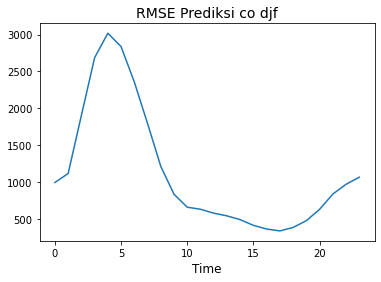

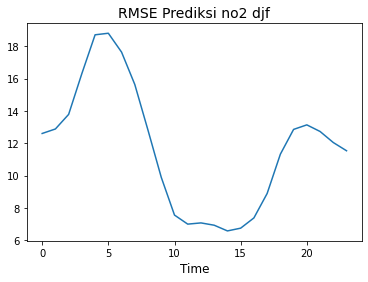

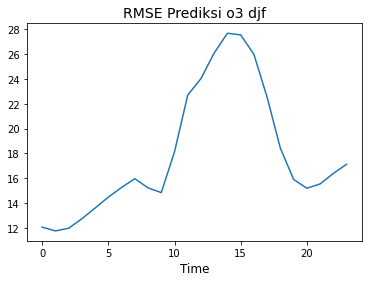

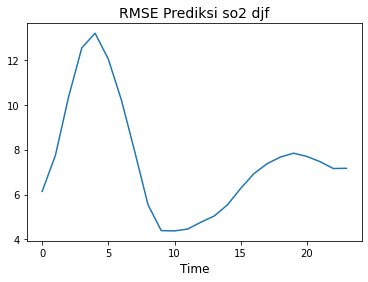

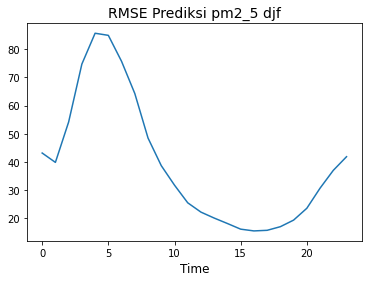

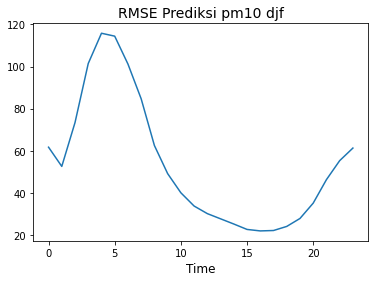

In [127]:
season = "djf"
for n,var in enumerate(pollutan_var):
    # Plot the histogram
    error_var = RMSE_djf[var]
    #t_24 = np.arange(1,25)
    plt.plot(error_var)
    plt.xlabel('Time', fontsize=12)
    #plt.ylabel('RMSE', fontsize=12)
    plt.title(f'RMSE Prediksi {var} {season}', fontsize=14)
    plt.show()

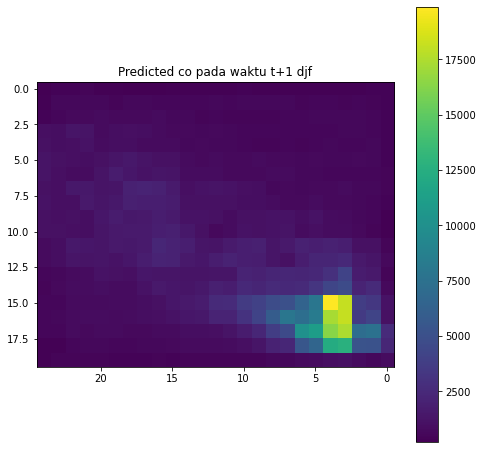

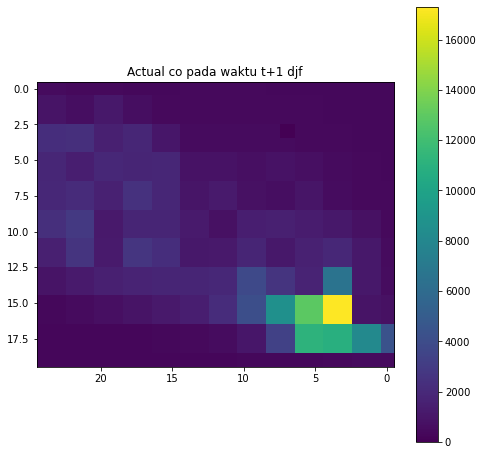

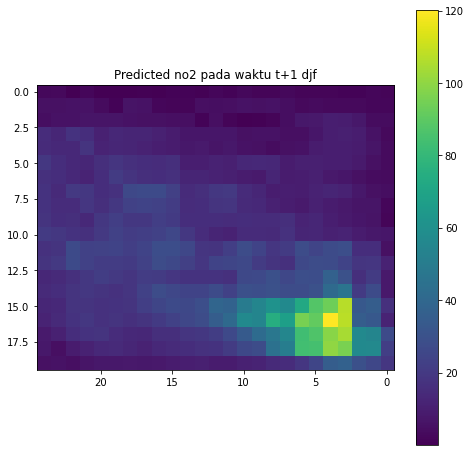

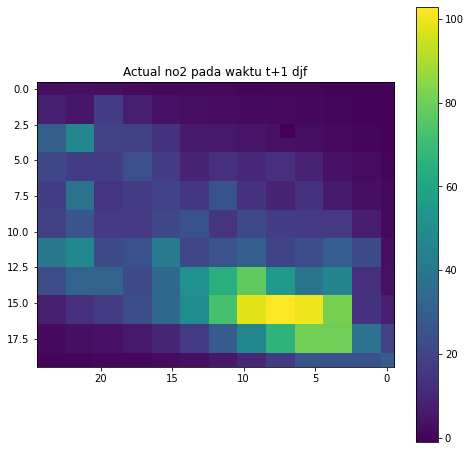

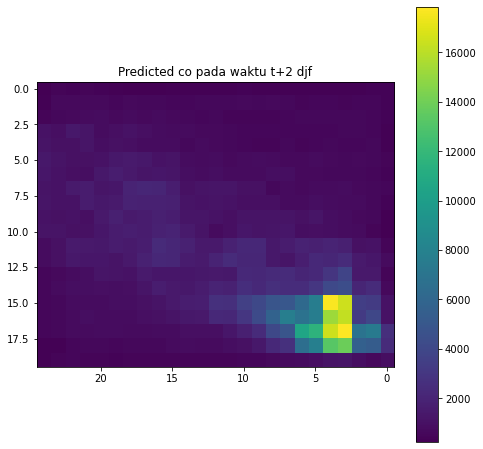

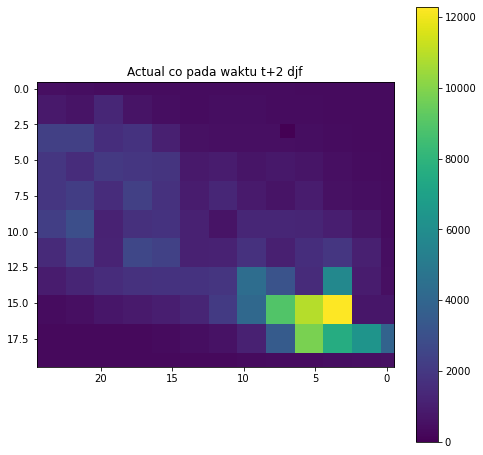

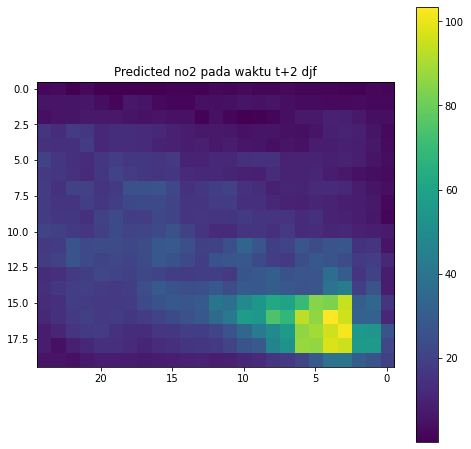

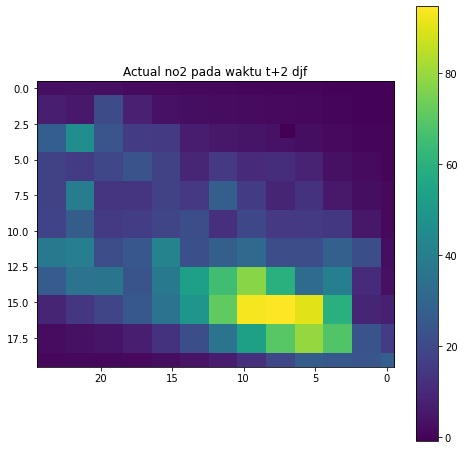

In [128]:
# t = 1
# v = 5
season = "djf"
for t in range(2):
    for v in range(2):
        # create a figure with a larger size
        fig, ax = plt.subplots(figsize=(8, 8))
        im = ax.imshow(predicted_djf[t,v,:,:], cmap='viridis')
        ax.invert_xaxis()
        plt.title(f'Predicted {var_data[v]} pada waktu t+{t+1} {season}')
        plt.colorbar(im)
        plt.show()

        # create a figure with a larger size
        fig, ax1 = plt.subplots(figsize=(8, 8))
        im = ax1.imshow(actual_djf[t,v,:,:], cmap='viridis')
        ax1.invert_xaxis()
        plt.title(f'Actual {var_data[v]} pada waktu t+{t+1} {season}')
        plt.colorbar(im)
        plt.show()

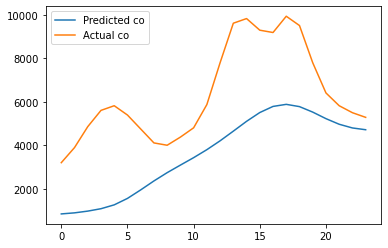

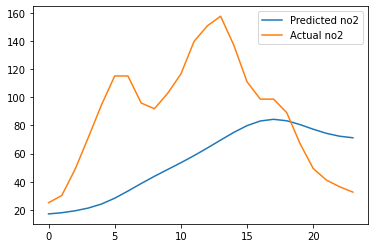

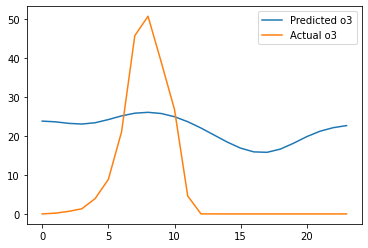

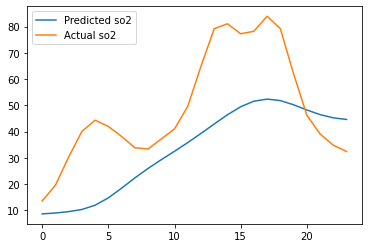

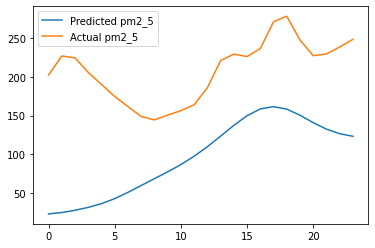

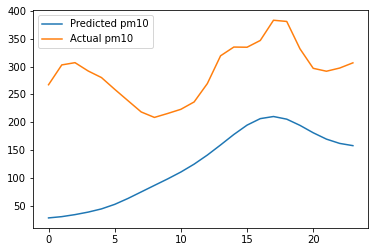

In [129]:
for i in range(6):
    idx_var = i
    plt.plot(predicted_mam[0:24,idx_var,12,12], label = f'Predicted {var_data[idx_var]}')
    plt.plot(actual_mam[0:24,idx_var,12,12], label = f'Actual {var_data[idx_var]}')
    plt.legend()
    plt.show()

#### ==========================================================================================================================

#### Code appendix

In [ ]:
dm = int(laten_val.shape[0]/4)
laten_mam, laten_jja, laten_son, laten_djf = laten_val[0:dm], laten_val[dm:2*dm], laten_val[2*dm:3*dm], laten_val[3*dm:4*dm] 

# X_train per season
X_mam_train, X_jja_train, X_son_train, X_djf_train = laten_mam[:-size_test], laten_jja[:-size_test], laten_son[:-size_test], laten_djf[:-size_test]

#y_test per season
y_mam_test, y_jja_test, y_son_test, y_djf_test =  laten_mam[-size_test:],laten_jja[-size_test:],laten_son[-size_test:],laten_djf[-size_test:]

#X_test per season
X_mam_test, X_jja_test, X_son_test, X_djf_test = X_mam_train[-len_seq:], X_jja_train[-len_seq:], X_son_train[-len_seq:], X_djf_train[-len_seq:]

# Buat data menjadi many to one type
X_mto_mam, y_mto_mam = many_to_one_laten(X_mam_train, len_seq)
X_mto_jja, y_mto_jja = many_to_one_laten(X_jja_train, len_seq)
X_mto_son, y_mto_son = many_to_one_laten(X_son_train, len_seq)
X_mto_djf, y_mto_djf = many_to_one_laten(X_djf_train, len_seq)

X_train_gabungan = torch.cat((X_mto_mam,X_mto_jja,X_mto_son,X_mto_djf), 0)
y_train_gabungan = torch.cat((y_mto_mam,y_mto_jja,y_mto_son,y_mto_djf), 0)
X_train_gabungan.shape, y_train_gabungan.shape

#### 4.1 Pisahkan data train dan data test pada setiap musim

In [98]:
#dm adalah distance musim, artinya jarak data antar musim
dm = int(val_data.shape[1]/4)
val_mam, val_jja, val_son, val_djf = val_data_scaled[0:dm,:,:,:], val_data_scaled[dm:2*dm,:,:,:], val_data_scaled[2*dm:3*dm,:,:,:], val_data_scaled[3*dm:4*dm,:,:,:] 

#print shape of each seasonal data
val_mam.shape, val_jja.shape, val_son.shape, val_djf.shape

((2143, 11, 20, 25),
 (2143, 11, 20, 25),
 (2143, 11, 20, 25),
 (2143, 11, 20, 25))

In [99]:
#define the size test and len_sequence 
size_test = 24
len_seq = 120

# X_train per season
X_mam_train, X_jj_train, X_son_train, X_djf_train = val_mam[0:-size_test],val_jja[0:-size_test],val_son[0:-size_test],val_djf[0:-size_test]

#y_test per season
y_mam_test, y_jja_test, y_son_test, y_djf_test =  val_mam[-size_test:],val_jja[-size_test:],val_son[-size_test:],val_djf[-size_test:]

#X_test per season
X_mam_test, X_jja_test, X_son_test, X_djf_test = X_mam_train[-len_seq:], X_jj_train[-len_seq:], X_son_train[-len_seq:], X_djf_train[-len_seq:]

In [100]:
print("Shape of train on each seasosn")
print(X_mam_train.shape, X_jj_train.shape, X_son_train.shape, X_djf_train.shape,'\n')

print("Shape of y_test on each seasosn")
print(y_mam_test.shape, y_jja_test.shape, y_son_test.shape, y_djf_test.shape,'\n')

print("Shape of X_test on each seasosn")
print(X_mam_test.shape, X_jja_test.shape, X_son_test.shape, X_djf_test.shape,'\n')

Shape of train on each seasosn
(2119, 11, 20, 25) (2119, 11, 20, 25) (2119, 11, 20, 25) (2119, 11, 20, 25) 

Shape of y_test on each seasosn
(24, 11, 20, 25) (24, 11, 20, 25) (24, 11, 20, 25) (24, 11, 20, 25) 

Shape of X_test on each seasosn
(120, 11, 20, 25) (120, 11, 20, 25) (120, 11, 20, 25) (120, 11, 20, 25) 



#### Gabungkan data train dari setiap musim

In [101]:
data_train = np.concatenate((X_mam_train, X_jj_train, X_son_train, X_djf_train ))
print(f"data train shape : {data_train.shape}")

data train shape : (8476, 11, 20, 25)


#### Ganti data pakai th aqi

In [17]:
#Digunakan untuk mengganti data pada setiap musim menggunakan threshold AQI
threshold = {"so2" : 350,
            "no2" : 200,
            "pm10" : 200,
            "pm2_5" :75,
            "co" : 15400,
            "o3" : 180}

def replace_ekstrem(data, features, threshold):
    new_val = data.copy()
    for n, var in enumerate(features):
        if var in threshold:
            th = threshold[var]
            val_var = data[n,:,:,:]
            val_var[val_var > th] = th+10
            new_val[n,:,:,:] = val_var
    return new_val

#val_data = replace_ekstrem(val_data, var_data, threshold)